In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sayan khanra\appdata\local\programs\python\python310\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, protobuf, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, tf-estimator-nightly, typing-extensions, wrapt
Required-by: 


In [71]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1]


In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


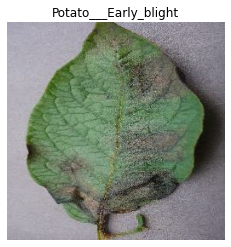

In [30]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")

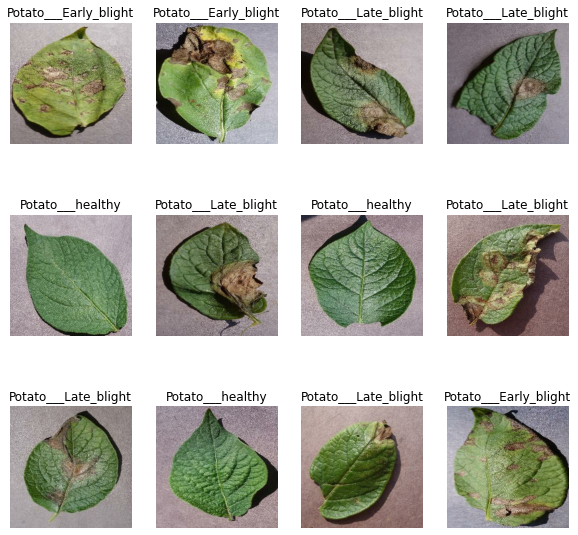

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
])

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(height_factor=(-0.3,-0.2)),
  layers.RandomRotation(0.2)
])

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [72]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [73]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)

Epoch 1/30
54/54 [==============================] - 92s 2s/step - loss: 0.8184 - accuracy: 0.5469 - val_loss: 0.8392 - val_accuracy: 0.6771
Epoch 2/30
54/54 [==============================] - 89s 2s/step - loss: 0.5641 - accuracy: 0.7523 - val_loss: 0.6863 - val_accuracy: 0.7708
Epoch 3/30
54/54 [==============================] - 89s 2s/step - loss: 0.4791 - accuracy: 0.7969 - val_loss: 0.9703 - val_accuracy: 0.6615
Epoch 4/30
54/54 [==============================] - 90s 2s/step - loss: 0.3722 - accuracy: 0.8478 - val_loss: 0.2246 - val_accuracy: 0.9167
Epoch 5/30
54/54 [==============================] - 91s 2s/step - loss: 0.2448 - accuracy: 0.9097 - val_loss: 0.2655 - val_accuracy: 0.9167
Epoch 6/30
54/54 [==============================] - 92s 2s/step - loss: 0.1497 - accuracy: 0.9456 - val_loss: 0.3144 - val_accuracy: 0.8958
Epoch 7/30
54/54 [==============================] - 91s 2s/step - loss: 0.1359 - accuracy: 0.9537 - val_loss: 0.2888 - val_accuracy: 0.8750
Epoch 8/30
54/54 [==

In [76]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 283ms/step - loss: 0.0670 - accuracy: 0.9688


In [77]:
scores

[0.0670405849814415, 0.96875]

In [78]:
history

In [79]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [80]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [81]:
history.history['accuracy']

[0.546875,
 0.7523148059844971,
 0.796875,
 0.8478009104728699,
 0.9097222089767456,
 0.9456018805503845,
 0.9537037014961243,
 0.9699074029922485,
 0.9473379850387573,
 0.9646990895271301,
 0.96875,
 0.9670138955116272,
 0.9699074029922485,
 0.9733796119689941,
 0.9756944179534912,
 0.9751157164573669,
 0.9785879850387573,
 0.9589120149612427,
 0.9820601940155029,
 0.9791666865348816,
 0.9849537014961243,
 0.9803240895271301,
 0.9791666865348816,
 0.9866898059844971,
 0.984375,
 0.9849537014961243,
 0.9942129850387573,
 0.9768518805503845,
 0.9855324029922485,
 0.9895833134651184]

In [82]:
len(history.history['accuracy'])

30

In [83]:
type(history.history['loss'])

list

In [84]:
history.history['loss'][:5]

[0.8184290528297424,
 0.5641488432884216,
 0.4790530800819397,
 0.37215352058410645,
 0.24478816986083984]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

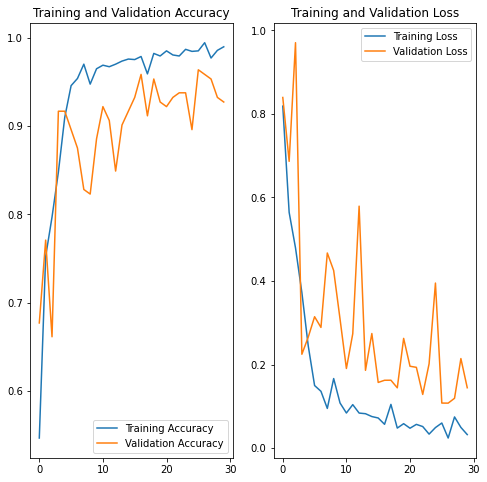

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


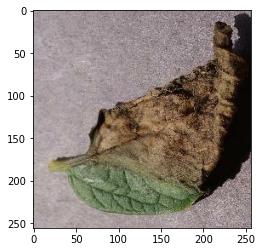

In [106]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [107]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

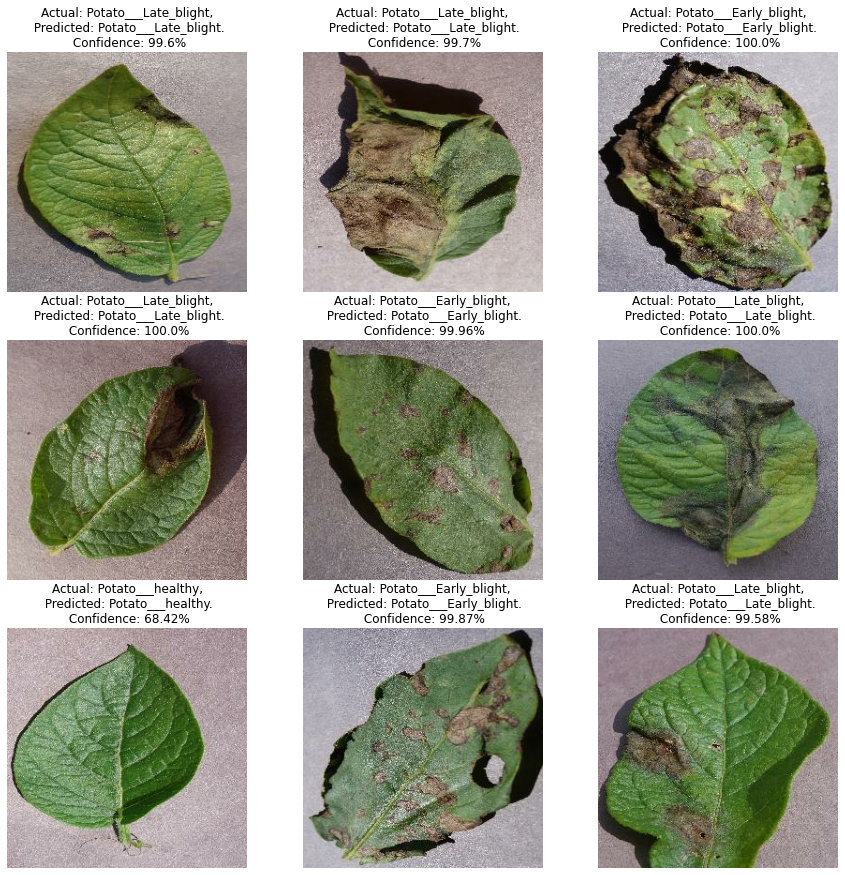

In [109]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [110]:
import os
model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets
